# Evaluation

In [8]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import csv
import sys
import json
import math
from nltk.tokenize import word_tokenize

from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, recall_score, precision_score

In [9]:
def get_child_dir_paths(dir_path):
    child_names = os.listdir(dir_path)
    child_paths = [os.path.join(dir_path,child_name) for child_name in child_names]
    dir_paths = [child_path for child_path in child_paths if os.path.isdir(child_path)]
    return dir_paths

In [10]:
pred_dir_path = 'data/pred'

pred_ent_filepaths = []
pred_rel_filepaths = []
pred_filepaths = dict()

c = 0

for dirpath in get_child_dir_paths(pred_dir_path):
    for filepath in os.listdir(dirpath):
        filepath = os.path.join(pred_dir_path,str(c),filepath)
        if 'ent' in filepath:
            pred_ent_filepaths.append(filepath)
        elif 'rel' in filepath:
            pred_rel_filepaths.append(filepath)

        pred_filepaths_in_dir = list(zip(pred_ent_filepaths, pred_rel_filepaths))
        pred_filepaths[c] = pred_filepaths_in_dir
    c += 1

pred_filepaths

{0: [('data/pred/0/extracted_psyllid_entities.txt',
   'data/pred/0/extracted_psyllid_relations.txt')],
 1: [('data/pred/0/extracted_psyllid_entities.txt',
   'data/pred/0/extracted_psyllid_relations.txt'),
  ('data/pred/1/extracted_psyllid_entities.txt',
   'data/pred/1/extracted_psyllid_relations.txt')]}

In [11]:
comparison_filepath = 'data/comparison.json'

In [12]:
ref_filepath = 'data/ref/cpruni_occurrences_binary.json'
pred_ent_filepath = 'data/extracted_psyllid_entities.txt'
pred_rel_filepath = 'data/extracted_psyllid_relations.txt'

In [13]:
reference_nomeclature_db_filepath = '../../../text-mining-workflow/ancillaries/psylve/psyllid_taxa.txt'
with open(reference_nomeclature_db_filepath, 'r') as f:
    reference_nomeclature_db = f.read()

## Entity Evaluation

with open(ref_filepath) as f:
    reference = json.load(f)
ref_documents = set(ref['common']['filename'] for ref in reference)
ref_entities = set()
for ref in reference:
    fn = ref['common']['filename']
    ref_entities.add(hashabledict(ref['left']))
    ref_entities.add(hashabledict(ref['right']))
for ref_entity in ref_entities:
    for a,v in ref_entity.items():
        print(a)


},
                    "pred": {
        

### Def: Evaluation Formulas

In [14]:
# Either reference and prediction document names are the same
def same_doc(ref, pred):
    return pred == ref or pred == ref + '_translation'


# Similarity between vectors
def sim_vector(ref, pred):
    #for token1 in word_tokenize(ref['acceptedNameUsage'].lower()):
        #for token2 in word_tokenize(pred['CANONICAL'].lower()):
            #if token1==token2:
            # FOR ALL HEMIPTERA: if token2 in reference_nomeclature_db.lower():
    if 'pruni' in pred['CANONICAL'].lower():
        return 1.0
    print('no match:',ref, pred)
    return 0.0

# Similarity between locations
def sim_location(ref, pred):
    for token1 in word_tokenize(ref['country'].lower()):
        for token2 in word_tokenize(pred['FORM'].lower()):
            if token1==token2:
                return 1.0
    return 0.0


# Similarity between hosts
def sim_host(ref, pred):
    for token1 in word_tokenize(ref['hostPlantLatinName'].lower()):
        for token2 in word_tokenize(pred['CANONICAL'].lower()):
            if token1==token2:
                return 1.0
    return 0.0

# Similarity between dates
def sim_date(ref, pred):
    if ref['eventDate'][-4:] == pred['FORM']:
        return 1.0
    return 0.0


TYPES = ('vector', 'location', 'host', 'date')

class hashabledict(dict):
    def __hash__(self):
        return hash(tuple(sorted(self.items())))
        

### Def: Form Pairs

In [15]:

sim_fun = {
    'vector': sim_vector,
    'location': sim_location,
    'host': sim_host,
    'date': sim_date
}


def sim(ref, pred):
    if ref['type'] != pred['TYPE']:
        return 0.0
    if not same_doc(ref['filename'], pred['DOC']):
        return 0.0
    return sim_fun[ref['type']](ref, pred)


def find_best_ent(paired_pred, ref_ent, pred_entities):
    max_sim = 0.0
    best_pred = None
    for pred_ent in pred_entities:
        if pred_ent in paired_pred:
            continue
        s = sim(ref_ent, pred_ent)
        if s == 0.0:
            continue
        if s > max_sim:
            max_sim = s
            best_pred = pred_ent
    return best_pred, max_sim


def pair_filter(pair, doc=None, type_=None, cat=None):
    r = pair['ref']
    p = pair['pred']
    if doc is not None:
        if r is not None and r['filename'] != doc:
            return False
        if p is not None and not same_doc(doc, p['DOC']):
            return False
    if type_ is not None:
        if r is not None and r['type'] != type_:
            return False
        if p is not None and p['TYPE'] != type_:
            return False
    if cat is not None:
        return cat == pair['cat']
    return True


### Def: Evaluate

In [16]:
def evaluate(ref_filepath, pred_ent_filepath, pred_rel_filepath):       
    with open(ref_filepath) as f:
        reference = json.load(f)
    ref_documents = set(ref['common']['filename'] for ref in reference)
    ref_entities = set()
    for ref in reference:
        fn = ref['common']['filename']
        ref_entities.add(hashabledict(ref['left']))
        ref_entities.add(hashabledict(ref['right']))


    with open(pred_ent_filepath, newline='') as f:
        entcsv = csv.DictReader(f, delimiter='\t')
        pred_entities = set(hashabledict(row) for row in entcsv)


    with open(pred_rel_filepath, newline='') as f:
        relcsv = csv.DictReader(f, delimiter='\t')
        pred_relations = set(hashabledict(row) for row in relcsv)



    TRUE_POSITIVE = 'True Positive'
    FALSE_POSITIVE = 'False Positive'
    FALSE_NEGATIVE = 'False Negative'


    ent_pairs = []
    paired_pred = set()
    for ref_ent in ref_entities:
        pred_ent, s = find_best_ent(paired_pred, ref_ent, pred_entities)
        if pred_ent is not None:
            paired_pred.add(pred_ent)
            cat = TRUE_POSITIVE
        else:
            cat = FALSE_NEGATIVE
        ent_pairs.append({'ref': ref_ent, 'pred': pred_ent, 'sim': s, 'cat': cat})
    for pred_ent in pred_entities:
        if pred_ent not in paired_pred:
            ent_pairs.append({'ref': None, 'pred': pred_ent, 'sim': 0.0, 'cat': FALSE_POSITIVE})


    def evaluate(pairs):
        tp = list(p for p in pairs if pair_filter(p, cat=TRUE_POSITIVE))
        fp = list(p for p in pairs if pair_filter(p, cat=FALSE_POSITIVE))
        fn = list(p for p in pairs if pair_filter(p, cat=FALSE_NEGATIVE))
        if len(tp) + len(fn) == 0:
            recall = math.nan
        else:
            recall = float(len(tp)) / (len(tp) + len(fn))
        if len(tp) + len(fp) == 0:
            precision = math.nan
        else:
            precision = float(len(tp)) / (len(tp) + len(fp))
        if recall + precision == 0:
            f1 = math.nan
        else:
            f1 = 2 * recall * precision / (recall + precision)
        return recall, precision, f1


    ent_eval = {}
    for doc in ref_documents:
        if str(doc) not in str(pred_entities):
            continue
        ent_doc_eval = {}
        for type_ in TYPES:
            pairs = list(p for p in ent_pairs if pair_filter(p, doc=doc, type_=type_))
            recall, precision, f1 = evaluate(pairs)
            ent_doc_eval[type_] = {
                'pairs': pairs,
                'recall': recall,
                'precision': precision,
                'f1': f1
            }
        ent_eval[doc] = ent_doc_eval
        recall, precision, f1 = evaluate(ent_pairs)
        ent_eval['global'] = {
            'recall': recall,
            'precision': precision,
            'f1': f1
        }

    with open(comparison_filepath, 'w+') as f:
        json.dump(ent_eval, f, indent=4)

    return ent_eval

## Evaluate

In [17]:
ent_evals = {}
c = 0

for dir,files in pred_filepaths.items():
    pred_ent_filepath = [path for path in files[0] if 'ent' in path][0]
    pred_rel_filepath = [path for path in files[0] if 'rel' in path][0]
    ent_eval = evaluate(ref_filepath, pred_ent_filepath, pred_rel_filepath)
    ent_evals[c] = ent_eval
    c+=1

ent_evals

no match: {'phylum': 'Arthropoda', 'class': 'Insecta', 'order': 'Hemiptera', 'suborder': 'Sternorrhyncha', 'superfamily': 'Psylloidea', 'family': 'Psyllidae Latreille, 1807', 'subfamily': 'Psyllinae Latreille, 1807', 'genus': 'Cacopsylla Ossiannilsson, 1970', 'acceptedNameUsage': 'Cacopsylla (Thamnopsylla) pruni (Scopoli, 1763)', 'type': 'vector', 'filename': '2012_Ozgen_Psyllids_Anatolie'} {'DOC': '2012_Ozgen_Psyllids_Anatolie_translation', 'TYPE': 'vector', 'FORM': 'Cacopsylla bidens', 'CANONICAL': 'Cacopsylla bidens'}
no match: {'phylum': 'Arthropoda', 'class': 'Insecta', 'order': 'Hemiptera', 'suborder': 'Sternorrhyncha', 'superfamily': 'Psylloidea', 'family': 'Psyllidae Latreille, 1807', 'subfamily': 'Psyllinae Latreille, 1807', 'genus': 'Cacopsylla Ossiannilsson, 1970', 'acceptedNameUsage': 'Cacopsylla (Thamnopsylla) pruni (Scopoli, 1763)', 'type': 'vector', 'filename': '2012_Ozgen_Psyllids_Anatolie'} {'DOC': '2012_Ozgen_Psyllids_Anatolie_translation', 'TYPE': 'vector', 'FORM': '

{0: {'1919_Horwood_blackthorn_Cacopsylla_pruni_UK': {'vector': {'pairs': [{'ref': {'phylum': 'Arthropoda',
       'class': 'Insecta',
       'order': 'Hemiptera',
       'suborder': 'Sternorrhyncha',
       'superfamily': 'Psylloidea',
       'family': 'Psyllidae Latreille, 1807',
       'subfamily': 'Psyllinae Latreille, 1807',
       'genus': 'Cacopsylla Ossiannilsson, 1970',
       'acceptedNameUsage': 'Cacopsylla (Thamnopsylla) pruni (Scopoli, 1763)',
       'type': 'vector',
       'filename': '1919_Horwood_blackthorn_Cacopsylla_pruni_UK'},
      'pred': None,
      'sim': 0.0,
      'cat': 'False Negative'},
     {'ref': None,
      'pred': {'DOC': '1919_Horwood_blackthorn_Cacopsylla_pruni_UK_translation',
       'TYPE': 'vector',
       'FORM': 'Homoptera',
       'CANONICAL': 'Homoptera'},
      'sim': 0.0,
      'cat': 'False Positive'},
     {'ref': None,
      'pred': {'DOC': '1919_Horwood_blackthorn_Cacopsylla_pruni_UK_translation',
       'TYPE': 'vector',
       'FORM': '

## JSON to DF

ref = []
for docname,entities in ent_eval.items():
    for entname,pairs_n_scores in entities.items():
        for pair in pairs_n_scores['pairs']:
            attributes = set()
            for attribute in pair['ref'].items()+pair['pred'].items():
                attributes.add(attribute)
            

In [18]:
from collections import defaultdict

ref_df = dict(docname=[],entname=[])
pred_df = dict(docname=[],entname=[])

for docname,entities in ent_eval.items():
    ref_df['docname'].append(docname)
    pred_df['docname'].append(docname)
    
    for entname,pairs_n_scores in entities.items():
        pred_df['entname'].append(entname)
        ref_df['entname'].append(entname)
        try:
            for pair in pairs_n_scores['pairs']:
                try:
                    for a,v in pair['ref'].items():
                        if a not in ref_df.keys():
                            ref_df[a] = []
                        ref_df[a].append(v)
                except AttributeError:
                    pass
                try:
                    for a,v in pair['pred'].items():
                        if a not in ref_df.keys():
                            pred_df[a] = []
                        pred_df[a].append(v)
                except AttributeError:
                    pass
                sizes = []
                for k in ref_df.keys():
                    sizes.append(len(ref_df[k]))
                for k in ref_df.keys():
                    if len(ref_df[k]) < max(sizes):
                        ref_df[k].extend([math.nan]*(max(sizes) - len(ref_df[k])))
                sizes = []
                for k in pred_df.keys():
                    sizes.append(len(pred_df[k]))
                for k in pred_df.keys():
                    if len(pred_df[k]) < max(sizes):
                        pred_df[k].extend([math.nan]*(max(sizes) - len(pred_df[k])))
                
        except:
            pass

In [19]:
ref_df = pd.DataFrame(ref_df)
pred_df = pd.DataFrame(pred_df)
pred_df

,docname,entname,DOC,TYPE,FORM,CANONICAL
0,1919_Horwood_blackthorn_Cacopsylla_pruni_UK,vector,2012_Ozgen_Psyllids_Anatolie_translation,date,2007,2007
1,NaN,location,NaN,NaN,NaN,NaN
2,NaN,host,NaN,NaN,NaN,NaN
3,NaN,date,NaN,NaN,NaN,NaN
4,global,recall,NaN,NaN,NaN,NaN
5,2012_Ozgen_Psyllids_Anatolie,precision,NaN,NaN,NaN,NaN
6,NaN,f1,NaN,NaN,NaN,NaN
7,NaN,vector,NaN,NaN,NaN,NaN
8,NaN,location,NaN,NaN,NaN,NaN
9,NaN,host,NaN,NaN,NaN,NaN


# Scores

In [20]:
dummies = {'False Positive': (0,1),
            'False Negative': (1,0),
            'True Positive': (1,1),
            'True Negative': (0,0),
            }

dummies_inv = {v: k for k, v in dummies.items()}

In [21]:
def create_dummy(data):
    dummy_data = []
    for docname,entities in data.items():
        for entname,pairs_n_scores in entities.items():
            if type(pairs_n_scores) is float:
                continue
            for pair in pairs_n_scores['pairs']:
                label = pair['cat']
                dummy_data.append(dummies[label])

    dummy_df = pd.DataFrame(dummy_data, columns =['ref', 'pred'])
    
    return dummy_df

In [22]:
dummies_df = dict()
for k,enet_eval in ent_evals.items():
    dummies_df[k] = create_dummy(ent_eval)
for k,dummy_df in dummies_df.items():
    ref_dummy, pred_dummy = dummy_df['ref'], dummy_df['pred']
    dummies_df[k]=list(zip(ref_dummy, pred_dummy))


In [23]:
dummies_df.keys()


dict_keys([0, 1])

[Text(0.5, 12.5, 'predicted'), Text(30.5, 0.5, 'actual')]

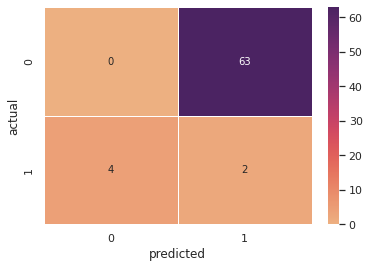

In [24]:
# plotting confusion matrix
conf_mat = confusion_matrix(ref_dummy, pred_dummy)
sns.set(font_scale=1)
matrix = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=.5, cmap='flare')
matrix.set(xlabel='predicted', ylabel='actual')

In [25]:
print(classification_report(ref_dummy, pred_dummy))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.03      0.33      0.06         6

    accuracy                           0.03        69
   macro avg       0.02      0.17      0.03        69
weighted avg       0.00      0.03      0.00        69



In [26]:
with open(comparison_filepath, 'r') as f:
    df = pd.read_json(f)

In [27]:
df.head()

,1919_Horwood_blackthorn_Cacopsylla_pruni_UK,global,2012_Ozgen_Psyllids_Anatolie
vector,"{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c...",NaN,"{'pairs': [{'ref': {'phylum': 'Arthropoda', 'c..."
location,{'pairs': [{'ref': {'country': 'United Kingdom...,NaN,"{'pairs': [{'ref': {'country': 'Turkey', 'coun..."
host,"{'pairs': [{'ref': None, 'pred': {'DOC': '1919...",NaN,"{'pairs': [], 'recall': None, 'precision': Non..."
date,"{'pairs': [{'ref': {'eventDate': '1852', 'type...",NaN,"{'pairs': [{'ref': {'eventDate': '2012', 'type..."
recall,NaN,0.001263,NaN


# Visualisation

In [28]:
from collections import Counter
from tools.visual import plot

In [29]:
counts =dict()

for k,dummy_df in dummies_df.items():
    counts[k] = dict(Counter(dummy_df))
counts


{0: {(1, 0): 4, (0, 1): 63, (1, 1): 2}, 1: {(1, 0): 4, (0, 1): 63, (1, 1): 2}}

In [30]:
df = pd.DataFrame([count.values() for count in counts.values()],columns=[dummies_inv[k] for k in counts[0].keys()])
#df = df.reset_index()
df

rows = []
for col_name in df.columns:
    col = df[col_name]
    for i in df.index:
        rows.append((i,col_name,df[col_name].iloc[i]))

df = pd.DataFrame(rows, columns=['i','cat','val'])
df

,i,cat,val
0,0,False Negative,4
1,1,False Negative,4
2,0,False Positive,63
3,1,False Positive,63
4,0,True Positive,2
5,1,True Positive,2


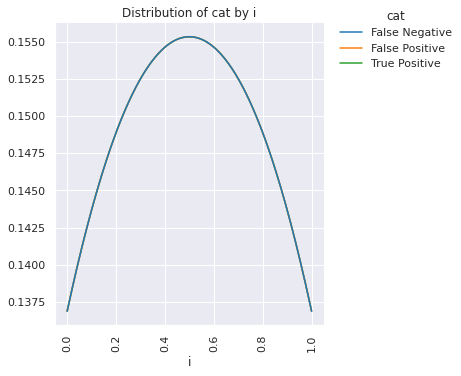

In [31]:
x = 'i'
hue = 'cat'
palette = sns.color_palette('tab10',n_colors=2)

plot(x=x, hue=hue, data=df,
    type='dist'
    )